# 通过两个模型Instance segmentation + pose筛选出SWD

yolo11n_pose_v2.yaml 最好的pose

yolo11n_pose_v5.yaml 最好的pose+box

yolo11n_det_v1.yaml 最好的point box

回顾上步：

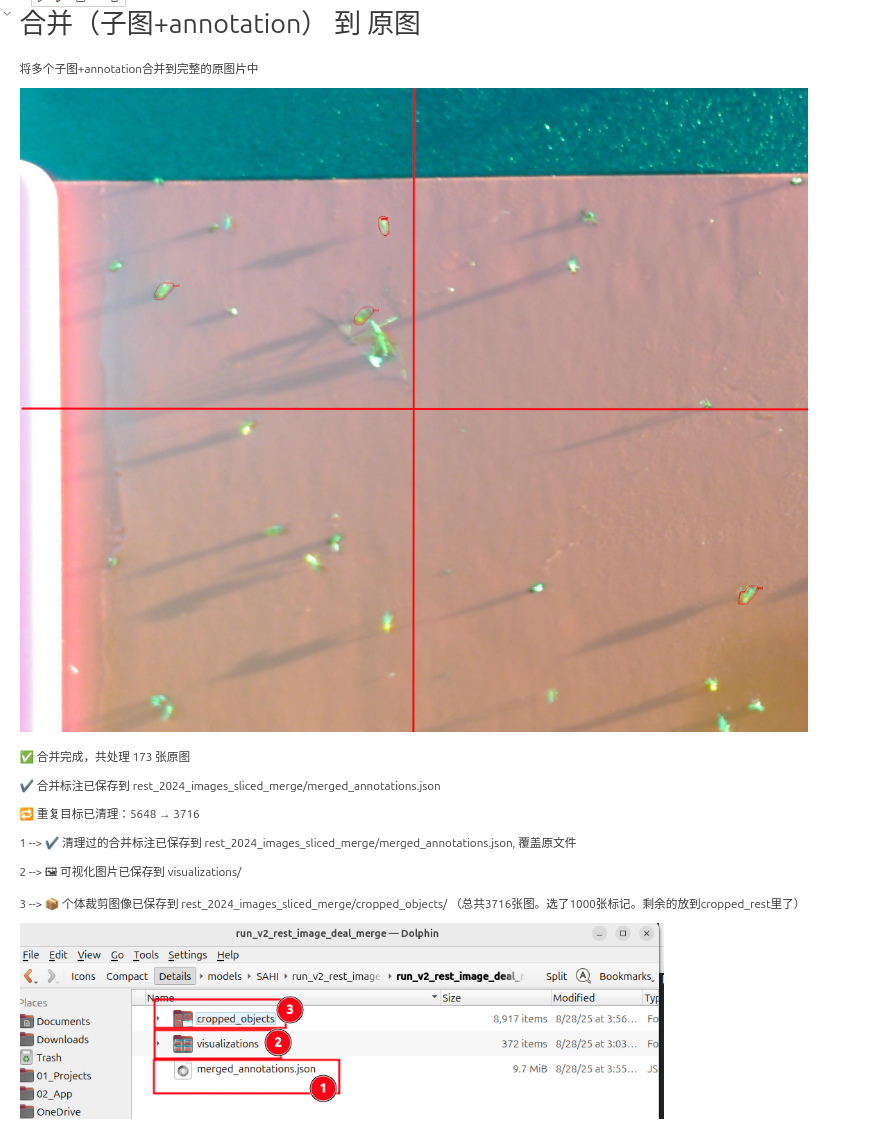

# 查看根目录下需要运行的文件夹

In [91]:
from pathlib import Path
version = "v8"
if __name__ == "__main__":
    # === 1) 给定一个根目录 ===
    root_dir = Path("/workspace/models/SAHI/run_v7")
    # end_with = "_sliced"
    end_with = "_data"

    # === 2) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("*/*" + end_with))


    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        exit(0)

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 3) 让你选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs
    
    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

    # 如果有的文件夹的raw_data里面没有图片，就移除
    chosen_dirs = [d for d in chosen_dirs if (d.parent / "raw_data").exists() and any((d.parent / "raw_data").glob("*.jpg"))]
    if not chosen_dirs:
        print(f"没有找到包含图片的 *{end_with} 目录")
        exit(0)

找到以下 _data 数据集：
[0] /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data
[1] /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data
[2] /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data
[3] /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data
[4] /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data
[5] /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data
[6] /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data
[7] /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data
[8] /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data
[9] /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data
[10] /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data
[11] /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data
[12] /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data
[13] /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data
[14] /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data
[15] /workspace/models/SAHI/run_v7/ms1_0809-0823_

将处理以下 _data 目录：
- 1. /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data
- 2. /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data
- 3. /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data
- 4. /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data
- 5. /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data
- 6. /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data
- 7. /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data
- 8. /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data
- 9. /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data
- 10. /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data
- 11. /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data
- 12. /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data
- 13. /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data
- 14. /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data
- 15. /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data
- 16. /workspace/models/SAHI/run_

# 0301 运行 Pose Estimation（在 cropped_objects 上）
读取每张小图（带 uuid_... 命名），输出头(h)、左翼(lp)、右翼(rp) 三关键点

In [92]:
import re, os, json
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Any, Optional

import numpy as np
from ultralytics import YOLO

# ==== 路径配置（按需修改）====
POSE_MODEL = "/workspace/models/best_model/yolo11n-pose-best_v2.pt"

# 文件名解析：..._uuid_<uuid>.jpg
UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)
ORIG_RE = re.compile(r"^(\d+_\d+_\d+)_obj", re.IGNORECASE)

# 关键点标签顺序（按你训练时的顺序！）
KPT_NAMES = ["h", "lp", "rp"]  # head / left wing / right wing

def run_pose_on_dir(model_path: str, input_dir: Path, out_json: Path):
    if not any(input_dir.glob("*.jpg")) and not any(input_dir.glob("*.png")):
        print(f"⚠️ 输入目录无图片：{input_dir}")
        return
    
    print(f"加载姿态模型：{model_path}")
    model = YOLO(model_path)
    results = model.predict(
        source=str(input_dir),
        imgsz=640,
        conf=0.88,
        iou=0.5,
        device=0,
        verbose=False,
        stream=True,
    )

    out: List[Dict[str, Any]] = []
    for res in results:
        fpath = getattr(res, "path", "")
        fname = os.path.basename(fpath)
        m_uuid = UUID_RE.search(fname)
        uuid_str = m_uuid.group(1) if m_uuid else None
        m_orig = ORIG_RE.match(fname)
        original_name = m_orig.group(1) if m_orig else None

        # 可能有多实例（多虫）——通常裁剪单虫，但仍做循环保险
        dets = []
        kpts = getattr(res, "keypoints", None)
        if kpts is not None and kpts.data is not None:
            # shape: (num_instances, num_kpts, 2 or 3)
            arr = kpts.data.cpu().numpy()
            conf_arr = getattr(kpts, "conf", None)
            conf_arr = conf_arr.cpu().numpy() if conf_arr is not None else None

            for i in range(arr.shape[0]):
                pts = arr[i]  # (K,2) or (K,3)
                item = []
                for ki in range(min(len(KPT_NAMES), pts.shape[0])):
                    x, y = float(pts[ki][0]), float(pts[ki][1])
                    c = float(conf_arr[i][ki]) if (conf_arr is not None and conf_arr.shape == (arr.shape[0], pts.shape[0])) else None
                    item.append({"name": KPT_NAMES[ki], "x": x, "y": y, "conf": c})
                dets.append({"kpts": item})

        out.append({
            "path": fpath,
            "file": fname,
            "uuid": uuid_str,
            "original_name": original_name,
            "instances": dets
        })

    out_json.parent.mkdir(parents=True, exist_ok=True)
    with out_json.open("w", encoding="utf-8") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)
    print(f"✅ Pose 结果保存：{out_json}")

# ==== 批处理所有 chosen_dirs ====
for d in chosen_dirs:
    crops_dir = d.parent / (d.name + "_sliced_merge") / "cropped_objects"
    pose_json = d.parent / (d.name + "_sliced_merge") / "pose_predicted_results.json"
    print(f"\n=== Pose on: {crops_dir} ===")
    run_pose_on_dir(POSE_MODEL, crops_dir, pose_json)



=== Pose on: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/cropped_objects ===
加载姿态模型：/workspace/models/best_model/yolo11n-pose-best_v2.pt
✅ Pose 结果保存：/workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/pose_predicted_results.json

=== Pose on: /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/cropped_objects ===
加载姿态模型：/workspace/models/best_model/yolo11n-pose-best_v2.pt
✅ Pose 结果保存：/workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/pose_predicted_results.json

=== Pose on: /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/cropped_objects ===
加载姿态模型：/workspace/models/best_model/yolo11n-pose-best_v2.pt
✅ Pose 结果保存：/workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/pose_predicted_results.json

=== Pose on: /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data_sliced_merge/cropped_objects ===
加载姿态模型：/workspace/models/best_model/yolo11n-pose-best_v2.pt
✅ Pose 结果保存：

In [93]:
# 绘制关键点到图片上
import cv2
import random
import json

def draw_keypoints_on_image(image_path: Path, pose_data: Dict[str, Any], out_path: Optional[Path] = None):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"⚠️ 无法读取图片: {image_path}")
        return

    for instance in pose_data.get("instances", []):
        kpts = instance.get("kpts", [])
        for kpt in kpts:
            x, y = int(kpt["x"]), int(kpt["y"])
            name = kpt["name"]
            conf = kpt.get("conf", 1.0)
            if name == "h":
                color = (255, 0, 0)  # 蓝色
            else:
                color = (0, 0, 255)  # 红色
            cv2.circle(image, (x, y), 1, color, -1)
            cv2.putText(image, f"{conf:.2f}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.18, color, 1)

    if out_path:
        cv2.imwrite(str(out_path), image)
        print(f"✅ 绘制结果保存: {out_path}")
    else:
        cv2.imshow("Keypoints", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return image
# ==== 绘制所有结果 ====
for d in chosen_dirs[:1]:  # 这里只看第一个目录，按需调整
    pose_json_path = d.parent / (d.name + "_sliced_merge") / "pose_predicted_results.json"
    if not pose_json_path.exists():
        print(f"⚠️ Pose 结果文件不存在: {pose_json_path}")
        continue

    with pose_json_path.open("r", encoding="utf-8") as f:
        pose_results = json.load(f)

    # 创建输出目录
    vis_dir = d.parent / (d.name + "_sliced_merge") / "07_pose_visualizations"
    vis_dir.mkdir(parents=True, exist_ok=True)

    for item in pose_results[:3]:  # 每个目录只看前10张，按需调整
        img_path = Path(item["path"])
        if not img_path.exists():
            print(f"⚠️ 图片不存在: {img_path}")
            continue
        out_img_path = vis_dir / img_path.name
        draw_keypoints_on_image(img_path, item, out_img_path)
        # draw_keypoints_on_image(img_path, item)  # 也弹窗显示

print("\n所有处理完成！")

✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/07_pose_visualizations/0718_1235_760_obj0_swd_uuid_7c4bcca9-d49c-452a-8d9f-be17efcb6b50.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/07_pose_visualizations/0718_1236_800_obj0_swd_uuid_2b548524-e4ac-4970-bc3b-1ebfa5e9d9b8.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/07_pose_visualizations/0718_1239_880_obj0_swd_uuid_9064ea2d-5d3b-4c01-a6dd-cc14d6789296.jpg

所有处理完成！


# 0302 运行“小黑点”检测（在 cropped_objects 上）
输出每张小图里的小黑点矩形框（class=black_dot）

In [94]:
import os, re, json
from pathlib import Path
from typing import Dict, Any, List
from ultralytics import YOLO
import numpy as np

DOT_MODEL = "/workspace/models/best_model/yolo11n-det-best_v1.pt"  # ← 换成你的“小黑点检测”权重

UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)

def _to_float_list(x):
    # 把 numpy/tensor 标量安全转成 python float
    return [float(v) for v in x]

def run_dot_det_on_dir(model_path: str, input_dir: Path, out_json: Path, conf=0.3, iou=0.5):
    if not any(input_dir.glob("*.jpg")) and not any(input_dir.glob("*.png")):
        print(f"⚠️ 输入目录无图片：{input_dir}")
        return

    print(f"加载小黑点检测模型：{model_path}")
    model = YOLO(model_path)

    results = model.predict(
        source=str(input_dir),
        imgsz=640,
        conf=conf,
        iou=iou,
        device=0,
        verbose=False,
        stream=True
    )

    out: List[Dict[str, Any]] = []
    for res in results:
        fpath = getattr(res, "path", "")
        fname = os.path.basename(fpath)
        m_uuid = UUID_RE.search(fname)
        uuid_str = m_uuid.group(1) if m_uuid else None

        det_list = []
        boxes = getattr(res, "boxes", None)
        if boxes is not None:
            # ✅ 正确的取法：分别访问 xyxy / conf / cls
            # 注意：这些可能是 torch.Tensor；先 .cpu().numpy() 再转 float
            xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes, "xyxy") else None
            confs = boxes.conf.cpu().numpy() if hasattr(boxes, "conf") and boxes.conf is not None else None
            clses = boxes.cls.cpu().numpy() if hasattr(boxes, "cls") and boxes.cls is not None else None

            if xyxy is not None:
                n = xyxy.shape[0]
                for i in range(n):
                    x1, y1, x2, y2 = _to_float_list(xyxy[i].tolist())
                    conf_score = float(confs[i]) if confs is not None and i < len(confs) else None
                    cls_id = int(clses[i]) if clses is not None and i < len(clses) else 0
                    det_list.append({
                        "bbox": [x1, y1, x2, y2],
                        "conf": conf_score,
                        "cls": cls_id
                    })

        out.append({
            "path": fpath,
            "file": fname,
            "uuid": uuid_str,
            "boxes": det_list
        })

    out_json.parent.mkdir(parents=True, exist_ok=True)
    with out_json.open("w", encoding="utf-8") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)
    print(f"✅ 小黑点检测结果保存：{out_json}")

# ==== 批处理 chosen_dirs ====
for d in chosen_dirs:
    crops_dir = d.parent / (d.name + "_sliced_merge") / "cropped_objects"
    dot_json  = d.parent / (d.name + "_sliced_merge") / "dot_predicted_results.json"
    print(f"\n=== Dot-Det on: {crops_dir} ===")
    run_dot_det_on_dir(DOT_MODEL, crops_dir, dot_json)



=== Dot-Det on: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/cropped_objects ===
加载小黑点检测模型：/workspace/models/best_model/yolo11n-det-best_v1.pt
✅ 小黑点检测结果保存：/workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/dot_predicted_results.json

=== Dot-Det on: /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/cropped_objects ===
加载小黑点检测模型：/workspace/models/best_model/yolo11n-det-best_v1.pt
✅ 小黑点检测结果保存：/workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/dot_predicted_results.json

=== Dot-Det on: /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/cropped_objects ===
加载小黑点检测模型：/workspace/models/best_model/yolo11n-det-best_v1.pt
✅ 小黑点检测结果保存：/workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/dot_predicted_results.json

=== Dot-Det on: /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data_sliced_merge/cropped_objects ===
加载小黑点检测模型：/workspace/models/best_model/yolo11n-det-best_v

In [95]:
# # 绘制小黑点检测结果到图片上
import cv2
def draw_dots_on_image(image_path: Path, dot_data: Dict[str, Any], out_path: Optional[Path] = None):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"⚠️ 无法读取图片: {image_path}")
        return

    for box in dot_data.get("boxes", []):
        x1, y1, x2, y2 = [int(v) for v in box["bbox"]]
        conf = box.get("conf", 1.0)
        cls_id = box.get("cls", 0)
        # color = (0, 0, 255)  # 红色
        # cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        # cv2.putText(image, f"cls:{cls_id}({conf:.2f})", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

        if cls_id == 0:
            color = (255, 0, 0)  # 蓝色
        else:
            color = (0, 0, 255)  # 红色
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        # cv2.putText(image, f"{conf:.2f}", (x1, max(10,y1 - 25)), cv2.FONT_HERSHEY_SIMPLEX, 0.2, color, 1)

        

    if out_path:
        cv2.imwrite(str(out_path), image)
        print(f"✅ 绘制结果保存: {out_path}")
    else:
        cv2.imshow("Dot Detections", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return image
# ==== 绘制所有结果 ====
for d in chosen_dirs[:1]:  # 这里只看第一个目录，按需
    dot_json_path = d.parent / (d.name + "_sliced_merge") / "dot_predicted_results.json"
    if not dot_json_path.exists():
        print(f"⚠️ 小黑点检测结果文件不存在: {dot_json_path}")
        continue

    with dot_json_path.open("r", encoding="utf-8") as f:
        dot_results = json.load(f)

    # 创建输出目录
    vis_dir = d.parent / (d.name + "_sliced_merge") / "08_dot_visualizations"
    vis_dir.mkdir(parents=True, exist_ok=True)

    for item in dot_results[:30]:  # 每个目录只看前30张，按需调整
        img_path = Path(item["path"])
        if not img_path.exists():
            print(f"⚠️ 图片不存在: {img_path}")
            continue
        out_img_path = vis_dir / img_path.name
        draw_dots_on_image(img_path, item, out_img_path)
        # draw_dots_on_image(img_path, item)  # 也弹窗显示

print("\n所有处理完成！")

✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/08_dot_visualizations/0718_1235_760_obj0_swd_uuid_7c4bcca9-d49c-452a-8d9f-be17efcb6b50.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/08_dot_visualizations/0718_1236_800_obj0_swd_uuid_2b548524-e4ac-4970-bc3b-1ebfa5e9d9b8.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/08_dot_visualizations/0718_1239_880_obj0_swd_uuid_9064ea2d-5d3b-4c01-a6dd-cc14d6789296.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/08_dot_visualizations/0718_1239_880_obj1_swd_uuid_6dfdb640-2e81-43d0-996b-7bfb619a9408.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/08_dot_visualizations/0718_1239_880_obj2_swd_uuid_ea10a882-1a9f-43b4-b404-57805cad5ded.jpg
✅ 绘制结果保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/08_dot_visualizations/0718_1239_880_obj3_swd_uuid_30051c21-e129-427b-82

# 0303 匹配规则：两翼关键点分别落入两个不同的小黑点框 ⇒ 判定 SWD（含可视化与拷贝）


In [96]:
# %% [markdown]
# # 0303 匹配：两翼关键点分别落入两个不同的小黑点框 ⇒ 判定 SWD（含可视化与拷贝） — 加速版

import os, re, shutil
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import cv2
import numpy as np

# ---------- 可选：orjson 加速 ----------
try:
    import orjson as _fastjson
    def _loads(b: bytes): return _fastjson.loads(b)
    def _dumps(obj): return _fastjson.dumps(obj, option=_fastjson.OPT_INDENT_2)
except Exception:
    import json as _fastjson
    def _loads(b: bytes): return _fastjson.loads(b.decode("utf-8"))
    def _dumps(obj): return _fastjson.dumps(obj, indent=2, ensure_ascii=False).encode("utf-8")

# ====== 参数区（按需调整）======
REQUIRE_DIFFERENT_BOXES = True   # ✅ 两翼必须落入不同框
USE_POINT_CONF = True            # 若关键点带 conf，则应用阈值过滤
KPT_CONF_THR = 0.88
DO_VIS = False                    # 输出可视化图
LIMIT_VIS = None                 # 仅可视化前 N 张（None 为全部）
COPY_UNMATCHED = False            # 也拷贝未匹配样本，便于人工复核

UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)

# ---------- I/O ----------
def load_json(path: Path):
    with path.open("rb") as f:
        data = f.read()
    return _loads(data)

def save_json(obj: Any, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("wb") as f:
        f.write(_dumps(obj))

# ---------- 向量化点落框 ----------
# 输入：pt=(x,y), boxes: np.ndarray (N,4) [x1,y1,x2,y2] float32
# 输出：命中的索引数组（np.int32）
def hits_for_point(pt: Tuple[float, float], boxes: np.ndarray) -> np.ndarray:
    if boxes.size == 0:
        return np.empty((0,), dtype=np.int32)
    x, y = pt
    # (N,)
    cond = (x >= boxes[:, 0]) & (x <= boxes[:, 2]) & (y >= boxes[:, 1]) & (y <= boxes[:, 3])
    return np.flatnonzero(cond).astype(np.int32, copy=False)

def find_kpt(items: List[Dict[str, Any]], name: str) -> Optional[Dict[str, Any]]:
    # 保持 O(K) 扫描，但避开多次 dict.get
    for it in items:
        if it.get("name") == name:
            return it
    return None

def kpt_ok(k: Optional[Dict[str, Any]], use_point_conf: bool, thr: float) -> bool:
    if not k:
        return False
    if use_point_conf:
        conf = k.get("conf")
        if conf is not None:
            # 避免 try/except，直接按常见数值/字符串转 float
            try:
                return float(conf) >= thr
            except Exception:
                return False
    return True

def match_one(uuid_: str,
              pose_items: List[Dict[str, Any]],
              dot_boxes_np: np.ndarray,
              require_different_boxes: bool = True,
              use_point_conf: bool = True,
              kpt_conf_thr: float = 0.15) -> Dict[str, Any]:
    """对一张小图进行匹配判断：lp 与 rp 必须分别命中两个不同的小黑点框（向量化版）"""
    lp = find_kpt(pose_items, "lp")
    rp = find_kpt(pose_items, "rp")

    lp_ok = kpt_ok(lp, use_point_conf, kpt_conf_thr)
    rp_ok = kpt_ok(rp, use_point_conf, kpt_conf_thr)

    matched = False
    lp_in_idx = None
    rp_in_idx = None

    if lp_ok and rp_ok and dot_boxes_np.size:
        lp_hits = hits_for_point((lp["x"], lp["y"]), dot_boxes_np)
        rp_hits = hits_for_point((rp["x"], rp["y"]), dot_boxes_np)

        if lp_hits.size and rp_hits.size:
            if require_different_boxes:
                # 找一对不同索引：利用广播快速找到第一对
                # 等价原逻辑的 “第一对” —— 取 lexicographically 最小的一对
                # 生成笛卡尔积最省事但可能大；这里用集合优化：
                rp_set = set(int(i) for i in rp_hits.tolist())
                for i in lp_hits.tolist():
                    # 寻找 rp_set 中 != i 的任意元素
                    if i in rp_set:
                        # 如果 rp 还有其他不同于 i 的命中，选其一
                        # 这里继续尝试找 rp 中第一个 != i 的
                        for j in rp_hits.tolist():
                            if j != i:
                                lp_in_idx, rp_in_idx = i, j
                                matched = True
                                break
                        if matched:
                            break
                    else:
                        # 直接取 rp_hits[0]
                        lp_in_idx, rp_in_idx = i, int(rp_hits[0])
                        matched = True
                        break
                # 若上面没找到，再尝试反向
                if not matched and lp_hits.size > 1 and rp_hits.size > 1:
                    i = int(lp_hits[0]); j = int(rp_hits[1] if rp_hits[0] == i else rp_hits[0])
                    if i != j:
                        lp_in_idx, rp_in_idx = i, j
                        matched = True
            else:
                matched = True
                lp_in_idx = int(lp_hits[0])
                rp_in_idx = int(rp_hits[0])

    return {
        "uuid": uuid_,
        "matched": matched,
        "lp": lp,
        "rp": rp,
        "lp_box_idx": lp_in_idx,
        "rp_box_idx": rp_in_idx,
    }

def visualize_match(img_path: Path,
                    pose_items: List[Dict[str, Any]],
                    boxes_np: np.ndarray,
                    match_info: Dict[str, Any],
                    out_path: Path):
    """可视化：小黑点框（细线），关键点小圆点"""
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None:
        return
    vis = img.copy()

    lp_idx = match_info.get("lp_box_idx")
    rp_idx = match_info.get("rp_box_idx")

    # 画框：绿色；lp 命中红；rp 命中蓝；两者同框紫色（虽然默认不允许）
    if boxes_np.size:
        for i in range(boxes_np.shape[0]):
            x1, y1, x2, y2 = boxes_np[i]
            lp_hit = (lp_idx == i)
            rp_hit = (rp_idx == i)
            if lp_hit and rp_hit:
                color = (255, 0, 255)
            elif lp_hit:
                color = (0, 0, 255)
            elif rp_hit:
                color = (255, 0, 0)
            else:
                color = (0, 255, 0)
            cv2.rectangle(vis, (int(x1), int(y1)), (int(x2), int(y2)), color, 1)

    # 画关键点：h=蓝，其余=红（与你现有颜色保持一致）
    for k in pose_items:
        if not k:
            continue
        px, py = int(k["x"]), int(k["y"])
        name = k.get("name", "?")
        color = (255, 0, 0) if name == "h" else (0, 0, 255)
        cv2.circle(vis, (px, py), 2, color, -1)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), vis)

# ====== 批处理所有 chosen_dirs ======
for d in chosen_dirs:
    base = d.parent / (d.name + "_sliced_merge")
    crops_dir = base / "cropped_objects"

    pose_json = base / "pose_predicted_results.json"
    dot_json  = base / "dot_predicted_results.json"
    out_json  = base / "swd_confirmed.json"
    vis_dir   = base / "09_swd_confirmed_vis"

    if not pose_json.exists() or not dot_json.exists():
        print(f"⚠️ 缺少输入：{pose_json} 或 {dot_json}，跳过 {d}")
        continue

    pose_list: List[Dict[str, Any]] = load_json(pose_json)
    dot_list:  List[Dict[str, Any]] = load_json(dot_json)

    # ---------- 预处理 dot_list：uuid -> np.ndarray(N,4) ----------
    dot_map_np: Dict[str, np.ndarray] = {}
    for item in dot_list:
        u = item.get("uuid")
        if not u:
            fname = item.get("file") or os.path.basename(item.get("path", ""))
            m = UUID_RE.search(str(fname))
            u = m.group(1) if m else None
        if not u:
            continue

        boxes = item.get("boxes", [])
        if not boxes:
            dot_map_np[u] = np.empty((0, 4), dtype=np.float32)
            continue

        # 只收 bbox，过滤非 list/tuple
        arr = [b["bbox"] for b in boxes if isinstance(b, dict) and isinstance(b.get("bbox"), (list, tuple)) and len(b["bbox"]) == 4]
        if arr:
            dot_map_np[u] = np.asarray(arr, dtype=np.float32)
        else:
            dot_map_np[u] = np.empty((0, 4), dtype=np.float32)

    out_rows: List[Dict[str, Any]] = []
    matched_cnt = 0
    total_cnt = 0
    vis_written = 0

    if DO_VIS:
        vis_dir.mkdir(parents=True, exist_ok=True)

    # ---------- 主循环（热点路径只走 Python 最少分支） ----------
    for item in pose_list:
        uuid_ = item.get("uuid")
        total_cnt += 1

        insts = item.get("instances", [])
        if not insts:
            out_rows.append({"uuid": uuid_, "matched": False, "reason": "no_pose", "path": item.get("path"), "file": item.get("file")})
            continue

        pose_items = insts[0].get("kpts") or []
        boxes_np = dot_map_np.get(uuid_, np.empty((0, 4), dtype=np.float32))

        info = match_one(
            uuid_=uuid_,
            pose_items=pose_items,
            dot_boxes_np=boxes_np,
            require_different_boxes=REQUIRE_DIFFERENT_BOXES,
            use_point_conf=USE_POINT_CONF,
            kpt_conf_thr=KPT_CONF_THR,
        )
        info["boxes"] = boxes_np.tolist() if boxes_np.size else []
        info["path"]  = item.get("path")
        info["file"]  = item.get("file")
        out_rows.append(info)

        if info["matched"]:
            matched_cnt += 1

        if DO_VIS and (LIMIT_VIS is None or vis_written < LIMIT_VIS):
            fname = item.get("file")
            if fname:
                img_path = crops_dir / fname
                if img_path.exists():
                    out_img = vis_dir / f"{Path(fname).stem}_vis.jpg"
                    visualize_match(img_path, pose_items, boxes_np, info, out_img)
                    vis_written += 1

    # 保存 JSON（orjson 更快；无则回退）
    save_json(out_rows, out_json)

    # === 拷贝 matched 与（可选）unmatched 到独立文件夹（含原图与可视化） ===
    confirmed_raw = base / "09_confirmed_swd" / "raw"
    confirmed_vis = base / "09_confirmed_swd" / "vis"
    review_raw    = base / "09_review_unmatched" / "raw"
    review_vis    = base / "09_review_unmatched" / "vis"
    confirmed_raw.mkdir(parents=True, exist_ok=True)
    confirmed_vis.mkdir(parents=True, exist_ok=True)
    if COPY_UNMATCHED:
        review_raw.mkdir(parents=True, exist_ok=True)
        review_vis.mkdir(parents=True, exist_ok=True)

    copied_match = copied_unmatch = 0
    for info in out_rows:
        fname = info.get("file")
        if not fname:
            continue
        src_raw = crops_dir / fname
        if not src_raw.exists():
            continue
        src_vis = vis_dir / f"{Path(fname).stem}_vis.jpg"

        if info.get("matched", False):
            shutil.copy2(src_raw, confirmed_raw / fname)
            if src_vis.exists():
                shutil.copy2(src_vis, confirmed_vis / src_vis.name)
            copied_match += 1
        elif COPY_UNMATCHED:
            shutil.copy2(src_raw, review_raw / fname)
            if src_vis.exists():
                shutil.copy2(src_vis, review_vis / src_vis.name)
            copied_unmatch += 1

    # 统计打印
    match_ratio = (matched_cnt / total_cnt * 100.0) if total_cnt else 0.0
    print(f"\n=== 匹配完成: {d.name} ===")
    print(f"总小图: {total_cnt}")
    print(f"匹配为 SWD: {matched_cnt}")
    print(f"匹配率: {match_ratio:.2f}%")
    print(f"结果 JSON: {out_json}")
    print(f"已拷贝 matched: {copied_match} 张 -> {confirmed_raw} / {confirmed_vis}")
    if COPY_UNMATCHED:
        print(f"已拷贝 unmatched: {copied_unmatch} 张 -> {review_raw} / {review_vis}")
    if DO_VIS:
        print(f"可视化目录: {vis_dir} （已写 {vis_written} 张）")



=== 匹配完成: raw_data ===
总小图: 61163
匹配为 SWD: 679
匹配率: 1.11%
结果 JSON: /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/swd_confirmed.json
已拷贝 matched: 679 张 -> /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/09_confirmed_swd/raw / /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/09_confirmed_swd/vis

=== 匹配完成: raw_data ===
总小图: 3690
匹配为 SWD: 0
匹配率: 0.00%
结果 JSON: /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/swd_confirmed.json
已拷贝 matched: 0 张 -> /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/09_confirmed_swd/raw / /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/09_confirmed_swd/vis

=== 匹配完成: raw_data ===
总小图: 87957
匹配为 SWD: 0
匹配率: 0.00%
结果 JSON: /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/swd_confirmed.json
已拷贝 matched: 0 张 -> /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/09_confirmed_swd/raw / /workspace/